## Load Libraries

In [1]:
import cv2
import matplotlib
import numpy as np
import pandas as pd
import skimage.measure
import matplotlib.pyplot as plt
from glob import glob
from skimage.feature import greycomatrix, greycoprops
%matplotlib inline 

## Remove White Background (Threshold)

In [2]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

## Display Image

In [3]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

## Plot Image Grid

In [4]:
def plot_img_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].imshow(images[n], interpolation = 'nearest')
            axs[i, j].axis('off')
            n += 1       

## Convert Image Path to OpenCV Image (24-bit Color Palette)

In [5]:
def convert_img_path_to_cv_img(img_path_arr, threshold = 225, h = 100, w = 100):
    img_arr = []
    for img_path in img_path_arr:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (w,h),interpolation = cv2.INTER_AREA)
        img = remove_background(img, threshold)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_arr.append(img)
    return img_arr

## Display First 300 Images (24-bit Color Palette)

In [6]:
def show_300(folder_path, threshold = 225, h = 100, w = 100):
    folder_name = folder_path.split("\\")[1]
    all_images = glob(folder_path + "*.jpg")
    all_images = all_images[0:300]
    img_arr = convert_img_path_to_cv_img(all_images, threshold, h, w)
    plot_img_grid(img_arr, 15, 15, (10,10))

In [7]:
# for folder_path in glob('Dataset/*/'):
#     show_300(folder_path, 225, 100, 100)

In [96]:
np.linspace(0, 256, 9)

array([  0.,  32.,  64.,  96., 128., 160., 192., 224., 256.])

## Convert Val To RGB

In [9]:
# def convert_val_to_rgb(x):
#     if x >= 0 and x < 64:
#         return "00"
#     elif x >= 64 and x < 128:
#         return "55"
#     elif x >= 128 and x < 192:
#         return "AA"
#     else:
#         return "FF"

In [33]:
# def convert_val_to_rgb(x):
#     if x >= 0 and x < 42.5:
#         return "00"
#     elif x >= 42.5 and x < 85:
#         return "33"
#     elif x >= 85 and x < 127.5:
#         return "66"
#     elif x >= 127.5 and x < 170:
#         return "99"
#     elif x >= 170 and x < 212.5:
#         return "CC"
#     else:
#         return "FF" 

In [97]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 32:
        return "00"
    elif x >= 32 and x < 64:
        return "24"
    elif x >= 64 and x < 96:
        return "40"
    elif x >= 96 and x < 128:
        return "60"
    elif x >= 128 and x < 160:
        return "80"
    elif x >= 160 and x < 192:
        return "A0"
    elif x >= 192 and x < 224:
        return "C0"
    else:
        return "FF" 

## Convert Val To Bin

In [98]:
# def convert_val_to_bin(x):
#     if x >= 0 and x < 64:
#         return 0
#     elif x >= 64 and x < 128:
#         return 64
#     elif x >= 128 and x < 192:
#         return 128
#     else:
#         return 255

In [99]:
# def convert_val_to_bin(x):
#     if x >= 0 and x < 42.5:
#         return 42
#     elif x >= 42.5 and x < 85:
#         return 84
#     elif x >= 85 and x < 127.5:
#         return 127
#     elif x >= 127.5 and x < 170:
#         return 169
#     elif x >= 170 and x < 212.5:
#         return 212
#     else:
#         return 255

In [101]:
def convert_val_to_bin(x):
    if x >= 0 and x < 32:
        return 31
    elif x >= 32 and x < 64:
        return 63
    elif x >= 64 and x < 96:
        return 95
    elif x >= 96 and x < 128:
        return 127
    elif x >= 128 and x < 160:
        return 159
    elif x >= 160 and x < 192:
        return 191
    elif x >= 192 and x < 224:
        return 223
    else:
        return 255

## Pipeline 1-D

In [2]:
def pipeline_1d(img_path, convert_func, alpha = 1.5, beta = 0, threshold = 225, h = 100, w = 100):
    cv_img = cv2.imread(img_path)
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    cv_img = remove_background(cv_img, threshold)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_func)(img_squeeze)
    return img_convert

## Convert Image Path to OpenCV Image (6-bit Color Palette)

In [71]:
def convert_img_path_to_new_cv_img(img_path_arr, threshold = 225, h = 100, w = 100):
    img_arr = []
    for img_path in img_path_arr:
        new_img = pipeline_1d(img_path, convert_val_to_bin,threshold, h, w)
        new_img = new_img.reshape(h, w, 3)
        img_arr.append(new_img)
    return img_arr

## Display First 300 Images (6-bit Color Palette)

In [72]:
def show_300_new(folder_path, threshold = 225, h = 100, w = 100):
    folder_name = folder_path.split("\\")[1]
    all_images = glob(folder_path + "*.jpg")
    all_images = all_images[0:300]
    img_arr = convert_img_path_to_new_cv_img(all_images, threshold, h, w)
    plot_img_grid(img_arr, 15, 15, (10, 10))

In [73]:
# for folder_path in glob('Dataset/*/'):
#     show_300_new(folder_path, 225, 32, 32)

## Pipeline Color

In [74]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

## Pipeline Texture

In [75]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    tmp_dict["Mean"] = np.mean(img_gray)
    tmp_dict["Variance"] = np.var(img_gray)
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

## Pipeline Shape

In [76]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 2)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    return tmp_dict

## Pipeline Final

In [77]:
def pipeline_final(img_path,threshold = 225, w = 100, h = 100):
    final_dict = {}
    
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [105]:
img_path = "Dataset\\Orange\\0_100.jpg"

## Individual Normal Image

In [106]:
print(256 ** 3)

16777216


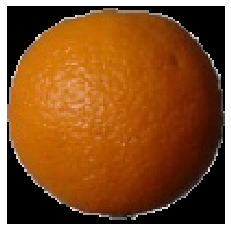

In [107]:
img = cv2.imread(img_path)
img = remove_background(img, 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

## Preprocessed Image

In [108]:
print(4**3)

64


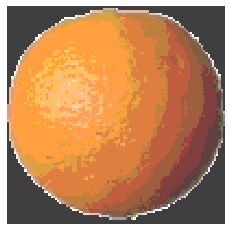

In [109]:
img = pipeline_1d(img_path, convert_val_to_bin, alpha = 1.0, beta = 40)
img = img.reshape((100, 100, 3))
display(img)

In [39]:
pipeline_final(img_path)

{'#000000': 2336,
 '#330000': 768,
 '#333300': 16,
 '#333333': 41,
 '#660000': 799,
 '#663300': 189,
 '#663333': 23,
 '#666633': 12,
 '#666666': 28,
 '#990000': 8,
 '#993300': 1723,
 '#993333': 2,
 '#996600': 77,
 '#996633': 91,
 '#996666': 24,
 '#999966': 25,
 '#999999': 35,
 '#CC3300': 304,
 '#CC6600': 2799,
 '#CC6633': 93,
 '#CC9900': 9,
 '#CC9933': 32,
 '#CC9966': 36,
 '#CC9999': 31,
 '#CCCC99': 20,
 '#CCCCCC': 27,
 '#FF6600': 98,
 '#FF6633': 15,
 '#FF9900': 55,
 '#FF9933': 222,
 '#FF9966': 25,
 '#FFCC99': 5,
 '#FFCCCC': 17,
 '#FFFFCC': 9,
 '#FFFFFF': 6,
 'Mean': 73.7538,
 'Variance': 2682.4851855600004,
 'Entropy': 6.229054497496583,
 'Contrast': 858.0138775510201,
 'Homogeneity': 0.34757277758614313,
 'Correlation': 0.8371938415296345,
 'Energy': 0.20225702202173604,
 'Area': 756.5,
 'Perimeter': 311.8650048971176}